In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [3]:
adnimerge = pd.read_csv("Files/ADNIMERGE_06Feb2025.csv")
adnimerge.head()

C:\Users\anisr\AppData\Local\Temp\ipykernel_12236\3712957585.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  adnimerge = pd.read_csv("Files/ADNIMERGE_06Feb2025.csv")


,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,1.33615,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
2,3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.498289,5.96721,6,6,2023-07-07 04:59:40.0
3,3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.999316,11.96720,12,12,2023-07-07 04:59:40.0
4,3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,1.998630,23.93440,24,24,2023-07-07 04:59:40.0


In [4]:
adnimerge[adnimerge['VISCODE'] == 'bl']['ORIGPROT'].value_counts()

ADNI1     819
ADNI2     790
ADNI3     690
ADNIGO    131
Name: ORIGPROT, dtype: int64

In [5]:
baseline_counts = adnimerge[adnimerge["VISCODE"] == "bl"]["RID"].nunique()

In [6]:
follow_up_counts = adnimerge.groupby("RID")["VISCODE"].count().reset_index()
follow_up_counts.columns = ["RID", "Total_Visits"]

In [7]:
longest_follow_ups = follow_up_counts.sort_values(
    by="Total_Visits", ascending=False)

In [8]:
longest_follow_ups.describe()

,RID,Total_Visits
count,2430.000000,2430.000000
mean,3727.081893,6.757613
std,2421.329437,4.740714
min,2.000000,1.000000
25%,1067.000000,3.000000
50%,4405.500000,5.000000
75%,6143.750000,9.000000
max,7125.000000,25.000000


In [9]:
longest_follow_ups.head()

,RID,Total_Visits
345,605,25
46,74,24
385,679,24
111,178,24
98,159,23


In [10]:
df = adnimerge[["RID", "VISCODE", "DX_bl", "DX", "EXAMDATE", "COLPROT"]]

In [11]:
df["DX_bl"].fillna("Unknown", inplace=True)
df["DX"].fillna("Unknown", inplace=True)



def get_visit_diagnosis_mapping(rid):
    subset = df[df["RID"] == rid].sort_values("VISCODE")
    visit_dx_dict = {}
    for _, row in subset.iterrows():
        if row["VISCODE"] == "bl":
            visit_dx_dict[row["VISCODE"]] = row["DX_bl"]  # Baseline DX
        else:
            visit_dx_dict[row["VISCODE"]] = row["DX"]  # Follow-up DX
    return visit_dx_dict


# Count total visits per participant
follow_up_counts = df.groupby("RID")["VISCODE"].count().reset_index()
follow_up_counts.columns = ["RID", "Total_Visits"]

# Track ADNI phases per participant
phases_per_participant = df.groupby("RID")["COLPROT"].unique().reset_index()
phases_per_participant.columns = ["RID", "Phases"]
phases_per_participant["Phases"] = phases_per_participant["Phases"].apply(
    lambda x: ", ".join(sorted(set(x))))

# Create the dictionary of visit-diagnosis mappings
visit_dx_df = pd.DataFrame({"RID": df["RID"].unique()})
visit_dx_df["Visit_Codes"] = visit_dx_df["RID"].apply(
    lambda x: get_visit_diagnosis_mapping(x))

# Merge all information into a final dataframe
follow_up_summary = follow_up_counts.merge(
    phases_per_participant, on="RID").merge(visit_dx_df, on="RID")

# Sort by number of visits
follow_up_summary = follow_up_summary.sort_values(
    by="Total_Visits", ascending=False)

C:\Users\anisr\AppData\Local\Temp\ipykernel_12236\4021822051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DX_bl"].fillna("Unknown", inplace=True)
C:\Users\anisr\AppData\Local\Temp\ipykernel_12236\4021822051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DX"].fillna("Unknown", inplace=True)


In [12]:
follow_up_summary[follow_up_summary['Total_Visits'] > 1]

,RID,Total_Visits,Phases,Visit_Codes
345,605,25,"ADNI1, ADNI2, ADNI3, ADNIGO","{'bl': 'CN', 'm06': 'CN', 'm108': 'MCI', 'm12'..."
46,74,24,"ADNI1, ADNI2, ADNI3, ADNIGO","{'bl': 'CN', 'm06': 'CN', 'm108': 'CN', 'm12':..."
385,679,24,"ADNI1, ADNI2, ADNI3","{'bl': 'LMCI', 'm06': 'MCI', 'm108': 'MCI', 'm..."
111,178,24,"ADNI1, ADNI2, ADNI3, ADNIGO","{'bl': 'LMCI', 'm06': 'MCI', 'm108': 'MCI', 'm..."
98,159,23,"ADNI1, ADNI2, ADNI3, ADNIGO","{'bl': 'CN', 'm06': 'CN', 'm108': 'CN', 'm12':..."
...,...,...,...,...
1851,6199,2,ADNI3,"{'bl': 'CN', 'm12': 'MCI'}"
2333,6956,2,ADNI3,"{'bl': 'SMC', 'm12': 'Unknown'}"
2042,6479,2,ADNI3,"{'bl': 'LMCI', 'm12': 'MCI'}"
1696,5231,2,ADNI2,"{'bl': 'AD', 'm06': 'Dementia'}"


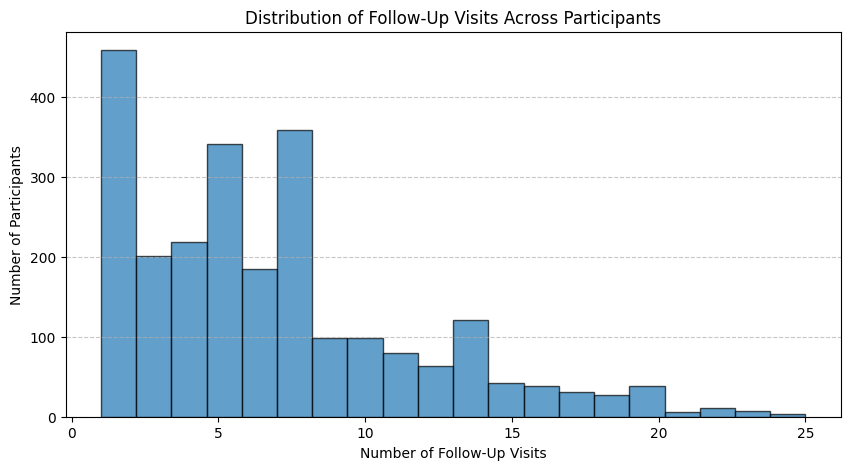

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(follow_up_summary["Total_Visits"],
         bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Number of Follow-Up Visits")
plt.ylabel("Number of Participants")
plt.title("Distribution of Follow-Up Visits Across Participants")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
from alluvial import plot
from collections import Counter

In [ ]:
follow_up_counts = df.groupby("RID")["VISCODE"].count().reset_index()
follow_up_counts.columns = ["RID", "Total_Visits"]

phases_per_participant = df.groupby("RID")["COLPROT"].unique().reset_index()
phases_per_participant.columns = ["RID", "Phases"]
phases_per_participant["Phases"] = phases_per_participant["Phases"].apply(
    lambda x: ", ".join(sorted(set(x))))


def get_visit_diagnosis_mapping(rid):
    subset = df[df["RID"] == rid]
    visit_dx_dict = {}
    for _, row in subset.iterrows():
        if row["VISCODE"] == "bl":
            visit_dx_dict[row["VISCODE"]] = row["DX_bl"]  
        else:
            visit_dx_dict[row["VISCODE"]] = row["DX"]  
    return visit_dx_dict


expanded_rows = []
for rid in df["RID"].unique():
    visit_dx_map = get_visit_diagnosis_mapping(rid)
    for visit, dx in visit_dx_map.items():
        expanded_rows.append({"RID": rid, "Visit": visit, "Diagnosis": dx})

df_expanded = pd.DataFrame(expanded_rows)

visit_order = sorted(df_expanded["Visit"].unique(), key=lambda x: (
    x[0], int(x[1:])) if x != "bl" else ("a", 0))
df_expanded["Visit"] = pd.Categorical(
    df_expanded["Visit"], categories=visit_order, ordered=True)

df_expanded["Node"] = df_expanded["Visit"].astype(
    str) + "_" + df_expanded["Diagnosis"]

In [10]:
from collections import Counter
nodes = list(df_expanded["Node"].unique())
node_indices = {node: i for i, node in enumerate(nodes)}

links = []
for rid in df_expanded["RID"].unique():
    subset = df_expanded[df_expanded["RID"] == rid].sort_values("Visit")
    previous_node = None
    for _, row in subset.iterrows():
        current_node = row["Node"]
        if previous_node is not None:
            links.append(
                {"source": node_indices[previous_node], "target": node_indices[current_node]})
        previous_node = current_node

link_counts = Counter((link["source"], link["target"]) for link in links)

source_nodes, target_nodes, values = zip(
    *[(s, t, count) for (s, t), count in link_counts.items()])

In [ ]:
transition_data = []

for rid in df["RID"].unique():
    subset = df[df["RID"] == rid].sort_values("VISCODE")

    first_dx = subset["DX_bl"].iloc[0]

    dx_followups = subset["DX"].dropna()
    if len(dx_followups) > 0:  
        last_dx = dx_followups.iloc[-1]
    else:
        last_dx = first_dx 


    if first_dx != last_dx:
        transition_data.append((first_dx, last_dx))

transition_counts = Counter(transition_data)


source_nodes, target_nodes, values = zip(
    *[(s, t, count) for (s, t), count in transition_counts.items()])

nodes = list(set(source_nodes).union(set(target_nodes)))
node_indices = {node: i for i, node in enumerate(nodes)}

source_indices = [node_indices[s] for s in source_nodes]
target_indices = [node_indices[t] for t in target_nodes]

fig = go.Figure(go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        label=nodes,
        color="lightblue"
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
))

fig.update_layout(
    title_text="Alluvial Plot of Diagnosis Transitions", font_size=12)
fig.show()

In [45]:
cn_follow_up = follow_up_summary[follow_up_summary["Total_Visits"] > 2]

cn_follow_up = cn_follow_up[cn_follow_up["Visit_Codes"].apply(
    lambda x: x.get("bl", None)) == "CN"]

transition_data = []

for _, row in cn_follow_up.iterrows():
    rid = row["RID"]
    visit_codes = row["Visit_Codes"] 

    transitions = list(visit_codes.values())
    visit_keys = list(visit_codes.keys())

    if len(set(transitions)) > 1:  
        first_dx = transitions[0]  
        last_dx = transitions[-1] 
        total_visits = row["Total_Visits"]

        transition_data.append({
            "RID": rid,
            "Baseline_DX": first_dx,
            "Final_DX": last_dx,
            "All_Diagnoses": transitions,
            "Visit_Codes": visit_keys,
            "Total_Visits": total_visits
        })

cn_transition_df = pd.DataFrame(transition_data)

In [60]:
follow_up_summary

,RID,Total_Visits,Phases,Visit_Codes
345,605,25,"ADNI1, ADNI2, ADNI3, ADNIGO","{'bl': 'CN', 'm06': 'CN', 'm108': 'MCI', 'm12'..."
46,74,24,"ADNI1, ADNI2, ADNI3, ADNIGO","{'bl': 'CN', 'm06': 'CN', 'm108': 'CN', 'm12':..."
385,679,24,"ADNI1, ADNI2, ADNI3","{'bl': 'LMCI', 'm06': 'MCI', 'm108': 'MCI', 'm..."
111,178,24,"ADNI1, ADNI2, ADNI3, ADNIGO","{'bl': 'LMCI', 'm06': 'MCI', 'm108': 'MCI', 'm..."
98,159,23,"ADNI1, ADNI2, ADNI3, ADNIGO","{'bl': 'CN', 'm06': 'CN', 'm108': 'CN', 'm12':..."
...,...,...,...,...
2051,6495,1,ADNI3,{'bl': 'SMC'}
2048,6492,1,ADNI3,{'bl': 'CN'}
820,2003,1,ADNIGO,{'bl': 'EMCI'}
823,2011,1,ADNIGO,{'bl': 'EMCI'}


In [62]:
df = adnimerge[["RID", "VISCODE", "DX_bl", "DX", "COLPROT"]]

# Count total participants in each ADNI phase
adni_phase_counts = df.groupby("COLPROT")["RID"].nunique().reset_index()
adni_phase_counts.columns = ["ADNI_Phase", "Total_Participants"]

# Count how many participants have follow-ups in multiple ADNI phases
longitudinal_participants = df.groupby(
    "RID")["COLPROT"].nunique().reset_index()
longitudinal_participants.columns = ["RID", "Number_of_Phases"]
multi_phase_counts = longitudinal_participants["Number_of_Phases"].value_counts(
).sort_index()

# Filter participants with multiple phases
multi_phase_rids = longitudinal_participants[longitudinal_participants["Number_of_Phases"] > 1]

C:\Users\anisr\AppData\Local\Temp\ipykernel_1312\3229251533.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




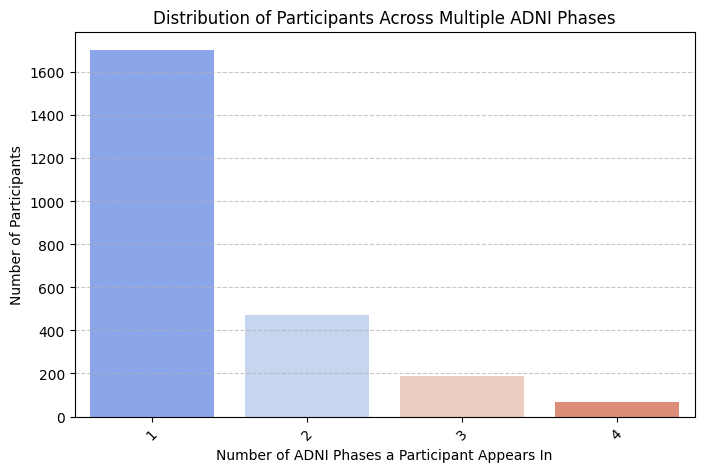

In [65]:
plt.figure(figsize=(8, 5))
sns.barplot(x=multi_phase_counts.index,
            y=multi_phase_counts.values, palette="coolwarm")
plt.xlabel("Number of ADNI Phases a Participant Appears In")
plt.ylabel("Number of Participants")
plt.title("Distribution of Participants Across Multiple ADNI Phases")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()

In [82]:
follow_up_summary[(follow_up_summary['Phases'].apply(lambda x: len(x.split(', ')) == 1)) & (follow_up_summary['Total_Visits'] > 1)]

,RID,Total_Visits,Phases,Visit_Codes
987,4063,11,ADNI2,"{'bl': 'EMCI', 'm03': 'Unknown', 'm06': 'MCI',..."
1003,4089,11,ADNI2,"{'bl': 'AD', 'm03': 'Unknown', 'm06': 'Dementi..."
1162,4338,11,ADNI2,"{'bl': 'AD', 'm03': 'Unknown', 'm06': 'Dementi..."
1044,4162,10,ADNI2,"{'bl': 'LMCI', 'm03': 'Unknown', 'm06': 'MCI',..."
1028,4136,10,ADNI2,"{'bl': 'AD', 'm03': 'Unknown', 'm06': 'Dementi..."
...,...,...,...,...
1851,6199,2,ADNI3,"{'bl': 'CN', 'm12': 'MCI'}"
2333,6956,2,ADNI3,"{'bl': 'SMC', 'm12': 'Unknown'}"
2042,6479,2,ADNI3,"{'bl': 'LMCI', 'm12': 'MCI'}"
1696,5231,2,ADNI2,"{'bl': 'AD', 'm06': 'Dementia'}"


In [96]:
df = adnimerge[['RID','VISCODE','DX_bl','DX']]
transition_data = []

for rid in df["RID"].unique():
    subset = df[df["RID"] == rid].sort_values("VISCODE")

    # Get baseline diagnosis
    baseline_dx = subset["DX_bl"].iloc[0]

    # Get all follow-up diagnoses
    follow_up_dx = subset["DX"].dropna().unique()

    # Check if the participant transitioned to another diagnosis
    if len(set(follow_up_dx)) > 1:
        converted = "Yes"
        final_dx = follow_up_dx[-1]  # Last recorded diagnosis
    else:
        converted = "No"
        final_dx = baseline_dx  # If no conversion, final remains the same

    # Store results
    transition_data.append({
        "RID": rid,
        "Baseline_DX": baseline_dx,
        "Converted?": converted,
        "Final_DX": final_dx
    })

# Convert to DataFrame
transition_df = pd.DataFrame(transition_data)

# Create summary table
conversion_summary = transition_df.groupby(
    ["Baseline_DX", "Converted?", "Final_DX"]).agg({"RID": "count"}).reset_index()
conversion_summary = conversion_summary.rename(
    columns={"RID": "Number of Participants"})

In [97]:
conversion_summary

,Baseline_DX,Converted?,Final_DX,Number of Participants
0,AD,No,AD,405
1,AD,Yes,MCI,6
2,CN,No,CN,432
3,CN,Yes,Dementia,19
4,CN,Yes,MCI,91
5,EMCI,No,EMCI,301
6,EMCI,Yes,CN,56
7,EMCI,Yes,Dementia,65
8,EMCI,Yes,MCI,1
9,LMCI,No,LMCI,338


In [98]:
conversion_summary['Number of Participants'].sum()

2419

In [102]:
adnimerge

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,1.33615,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
2,3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.498289,5.96721,6,6,2023-07-07 04:59:40.0
3,3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.999316,11.96720,12,12,2023-07-07 04:59:40.0
4,3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,1.998630,23.93440,24,24,2023-07-07 04:59:40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16416,4349,ADNI3,ADNI2,018_S_4349,18,m138,2023-03-30,CN,71.4,Female,...,17.82,1.33353,NaN,1.0344,NaN,11.351100,135.93400,138,138,2023-08-22 04:58:56.0
16417,6801,ADNI3,ADNI3,041_S_6801,41,m42,2023-06-30,SMC,61.0,Female,...,NaN,NaN,NaN,1.1509,NaN,3.701570,44.32790,42,42,2023-08-25 05:00:03.0
16418,5097,ADNI3,ADNI2,041_S_5097,41,m126,2023-08-16,SMC,67.5,Male,...,16.48,1.20863,NaN,1.1086,NaN,10.371000,124.19700,126,126,2023-08-26 05:00:28.0
16419,6515,ADNI3,ADNI3,007_S_6515,7,m60,2023-08-24,SMC,89.9,Female,...,NaN,NaN,NaN,NaN,1.1475,5.004790,59.93440,60,60,2023-08-29 04:58:51.0


In [81]:
adnimerge['RID'].nunique()

2430

In [3]:
adnimerge['RID'].nunique()

2430

In [4]:
adni_use = adnimerge[['RID','COLPROT','ORIGPROT','VISCODE','DX_bl','DX','AGE','M']]

In [5]:
adni_use

,RID,COLPROT,ORIGPROT,VISCODE,DX_bl,DX,AGE,M
0,2,ADNI1,ADNI1,bl,CN,CN,74.3,0
1,3,ADNI1,ADNI1,bl,AD,Dementia,81.3,0
2,3,ADNI1,ADNI1,m06,AD,Dementia,81.3,6
3,3,ADNI1,ADNI1,m12,AD,Dementia,81.3,12
4,3,ADNI1,ADNI1,m24,AD,Dementia,81.3,24
...,...,...,...,...,...,...,...,...
16416,4349,ADNI3,ADNI2,m138,CN,NaN,71.4,138
16417,6801,ADNI3,ADNI3,m42,SMC,NaN,61.0,42
16418,5097,ADNI3,ADNI2,m126,SMC,NaN,67.5,126
16419,6515,ADNI3,ADNI3,m60,SMC,NaN,89.9,60


In [6]:
adni_use['ORIGPROT'].value_counts()

ADNI1     7267
ADNI2     5852
ADNI3     2044
ADNIGO    1258
Name: ORIGPROT, dtype: int64

In [7]:
adni_use['COLPROT'].value_counts()

ADNI2     6945
ADNI1     5013
ADNI3     3659
ADNIGO     804
Name: COLPROT, dtype: int64

In [8]:
baseline_adni1 = adni_use[(adni_use['VISCODE'] == 'bl')
                          & (adni_use['COLPROT'] == 'ADNI1')]
baseline_adni2 = adni_use[(adni_use['VISCODE'] == 'bl')
                          & (adni_use['COLPROT'] == 'ADNI2')]

In [9]:
print(baseline_adni1.shape, baseline_adni2.shape)

(819, 8) (790, 8)


In [10]:
adni_sorted1 = baseline_adni1.sort_values(by=['RID', 'M'])
adni_sorted2 = baseline_adni2.sort_values(by=['RID', 'M'])

In [11]:
adni_sorted = adni_use.sort_values(by=['RID', 'M'])

In [12]:
cn_to_mci = set()
mci_to_ad = set()
transitions = []

for rid, group in adni_sorted.groupby('RID'):
    group = group.dropna(subset=['DX']).sort_values('M')

    if group.empty or 'DX_bl' not in group.columns:  
        continue  

    first_dx = group['DX_bl'].iloc[0] if not group['DX_bl'].isna(
    ).all() else None
    if first_dx is None:
        continue  

    previous_dx = first_dx
    converted = False  

    for _, row in group.iterrows():
        current_dx = row['DX']
        viscode = row['VISCODE']

        if previous_dx == 'CN' and current_dx == 'MCI':
            cn_to_mci.add(rid)
            transitions.append((rid, viscode, 'CN - MCI'))
            converted = True

        elif previous_dx == 'MCI' and current_dx == 'Dementia':  
            mci_to_ad.add(rid)
            transitions.append((rid, viscode, 'MCI - AD'))
            converted = True

        previous_dx = current_dx

transitions_df = pd.DataFrame(
    transitions, columns=['RID', 'VISCODE', 'Transition'])

print("\nTransition counts:")
print("CN → MCI:", len(cn_to_mci))
print("MCI → AD:", len(mci_to_ad))


Transition counts:
CN → MCI: 177
MCI → AD: 414


In [13]:
adni_sorted['RID'].nunique()

2430

In [14]:
transitions_df

,RID,VISCODE,Transition
0,2,m84,CN - MCI
1,2,m132,CN - MCI
2,8,m120,CN - MCI
3,15,m72,CN - MCI
4,22,m24,CN - MCI
...,...,...,...
611,6852,m24,MCI - AD
612,6908,m30,MCI - AD
613,6911,m12,MCI - AD
614,6969,m12,CN - MCI


In [15]:
transitions_rids = sorted(transitions_df[transitions_df['Transition'] == 'CN - MCI']['RID'].unique())

adni_sorted_rids = sorted(adni_sorted[(adni_sorted['DX_bl'] == 'CN') & (adni_sorted['DX'] == 'MCI')]['RID'].unique())

unmatched_rids = set(transitions_rids) - set(adni_sorted_rids)

print(len(transitions_rids), len(adni_sorted_rids))
if unmatched_rids:
    print("RIDs that haven't matched:", sorted(unmatched_rids))
    print(len(unmatched_rids))
else:
    print("All RIDs match.")

177 105
RIDs that haven't matched: [112, 138, 188, 668, 669, 722, 1074, 1245, 1352, 1408, 2007, 2036, 2123, 2150, 2180, 2187, 2301, 2304, 2315, 4061, 4168, 4199, 4214, 4351, 4359, 4380, 4381, 4512, 4513, 4624, 4706, 4785, 4799, 4813, 5096, 5097, 5121, 5130, 5132, 5135, 5166, 5207, 5214, 5219, 5227, 5234, 5237, 5253, 5258, 5263, 5265, 5273, 5277, 5282, 5285, 5294, 6001, 6033, 6061, 6111, 6173, 6189, 6279, 6291, 6327, 6330, 6333, 6350, 6371, 6411, 6744, 6834, 6969]
73


In [16]:
adni_sorted[adni_sorted['RID'].isin(unmatched_rids)]

,RID,COLPROT,ORIGPROT,VISCODE,DX_bl,DX,AGE,M
289,112,ADNI1,ADNI1,bl,LMCI,MCI,70.6,0
290,112,ADNI1,ADNI1,m06,LMCI,CN,70.6,6
291,112,ADNI1,ADNI1,m12,LMCI,MCI,70.6,12
292,112,ADNI1,ADNI1,m18,LMCI,MCI,70.6,18
293,112,ADNI1,ADNI1,m24,LMCI,CN,70.6,24
...,...,...,...,...,...,...,...,...
15554,6834,ADNI3,ADNI3,bl,SMC,CN,82.3,0
16015,6834,ADNI3,ADNI3,m30,SMC,MCI,82.3,30
13308,6969,ADNI3,ADNI3,bl,SMC,CN,68.5,0
16029,6969,ADNI3,ADNI3,m12,SMC,MCI,68.5,12


In [17]:
def track_diagnosis_transitions(adni_baseline, adni_data, adni_phase):

    adni_longitudinal = adni_data[adni_data['RID'].isin(adni_baseline['RID'])]
    adni_sorted = adni_longitudinal.sort_values(by=['RID', 'M'])

    cn_to_mci = set()
    mci_to_ad = set()
    transitions = []
    non_converters = {}

    for rid, group in adni_sorted.groupby('RID'):
        group = group.dropna(subset=['DX']).sort_values('M')

        if group.empty or 'DX_bl' not in group.columns:
            continue  
        first_dx = group['DX_bl'].iloc[0] if not group['DX_bl'].isna(
        ).all() else None
        if first_dx is None:
            continue

        previous_dx = first_dx
        converted = False

        for _, row in group.iterrows():
            current_dx = row['DX']
            viscode = row['VISCODE']

            if previous_dx == 'CN' and current_dx == 'MCI':
                cn_to_mci.add(rid)
                transitions.append((rid, viscode, 'CN → MCI'))
                converted = True

            elif previous_dx == 'MCI' and current_dx == 'Dementia':
                mci_to_ad.add(rid)
                transitions.append((rid, viscode, 'MCI → AD'))
                converted = True

            previous_dx = current_dx

        if not converted:
            non_converters[rid] = group['VISCODE'].nunique()

    transitions_df = pd.DataFrame(
        transitions, columns=['RID', 'VISCODE', 'Transition'])

    print(f"\nDiagnosis Transitions for {adni_phase}:")
    print(transitions_df)

    print(f"\nTransition counts for {adni_phase}:")
    print(f"CN → MCI: {len(cn_to_mci)}")
    print(f"MCI → AD: {len(mci_to_ad)}")
    print(f"Non-Converters: {len(non_converters)}")

    return transitions_df, non_converters


transitions_adni1, non_converters_adni1 = track_diagnosis_transitions(
    baseline_adni1, adni_use, "ADNI1")
transitions_adni2, non_converters_adni2 = track_diagnosis_transitions(
    baseline_adni2, adni_use, "ADNI2")


Diagnosis Transitions for ADNI1:
      RID VISCODE Transition
0       2     m84   CN → MCI
1       2    m132   CN → MCI
2       8    m120   CN → MCI
3      15     m72   CN → MCI
4      22     m24   CN → MCI
..    ...     ...        ...
318  1408     m36   CN → MCI
319  1412     m12   MCI → AD
320  1423     m12   MCI → AD
321  1425     m36   MCI → AD
322  1427     m12   MCI → AD

[323 rows x 3 columns]

Transition counts for ADNI1:
CN → MCI: 74
MCI → AD: 235
Non-Converters: 532

Diagnosis Transitions for ADNI2:
      RID VISCODE Transition
0    4005     m12   MCI → AD
1    4015     m24   MCI → AD
2    4030     m36   MCI → AD
3    4035     m12   MCI → AD
4    4041     m06   CN → MCI
..    ...     ...        ...
203  5277     m48   CN → MCI
204  5282     m84   CN → MCI
205  5285     m24   CN → MCI
206  5285     m54   MCI → AD
207  5294     m54   CN → MCI

[208 rows x 3 columns]

Transition counts for ADNI2:
CN → MCI: 74
MCI → AD: 127
Non-Converters: 593


In [18]:
adni_use['COLPROT'].value_counts()

ADNI2     6945
ADNI1     5013
ADNI3     3659
ADNIGO     804
Name: COLPROT, dtype: int64

In [19]:
baseline_adni1 = adni_use[(adni_use['VISCODE'] == 'bl')
                          & (adni_use['COLPROT'] == 'ADNI1')]
baseline_adni2 = adni_use[(adni_use['VISCODE'] == 'bl')
                          & (adni_use['COLPROT'] == 'ADNI2')]
baseline_adnigo = adni_use[(adni_use['VISCODE'] == 'bl')
                            & (adni_use['COLPROT'] == 'ADNIGO')]
baseline_adni3 = adni_use[(adni_use['VISCODE'] == 'bl')
                          & (adni_use['COLPROT'] == 'ADNI3')]

In [20]:
count_adni1 = baseline_adni1['RID'].nunique()
count_adni2 = baseline_adni2['RID'].nunique()
count_adnigo = baseline_adnigo['RID'].nunique()
count_adni3 = baseline_adni3['RID'].nunique()

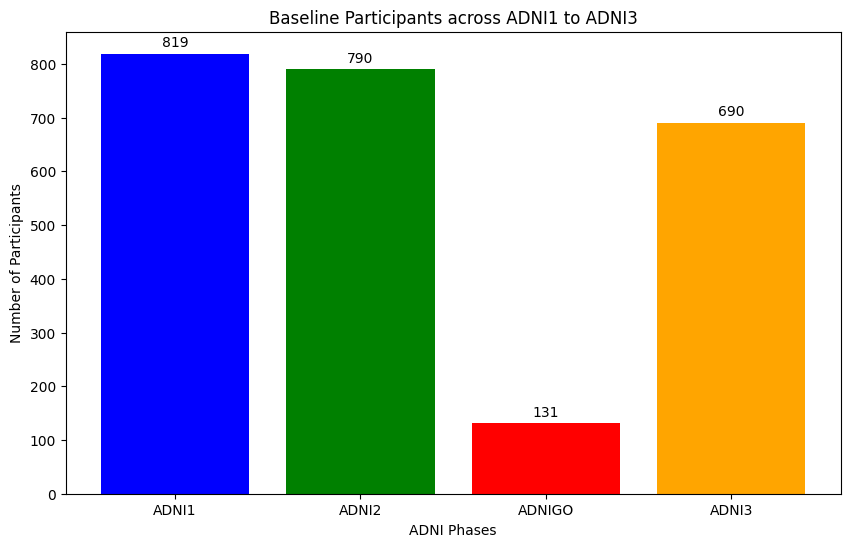

In [21]:
plt.figure(figsize=(10, 6))
counts = [count_adni1, count_adni2, count_adnigo, count_adni3]
labels = ['ADNI1', 'ADNI2', 'ADNIGO', 'ADNI3']
colors = ['blue', 'green', 'red', 'orange']

bars = plt.bar(labels, counts, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.title("Baseline Participants across ADNI1 to ADNI3")
plt.xlabel("ADNI Phases")
plt.ylabel("Number of Participants")
plt.show()

In [22]:
adni_use[adni_use['RID'].isin(baseline_adni1['RID'].unique())]

,RID,COLPROT,ORIGPROT,VISCODE,DX_bl,DX,AGE,M
0,2,ADNI1,ADNI1,bl,CN,CN,74.3,0
1,3,ADNI1,ADNI1,bl,AD,Dementia,81.3,0
2,3,ADNI1,ADNI1,m06,AD,Dementia,81.3,6
3,3,ADNI1,ADNI1,m12,AD,Dementia,81.3,12
4,3,ADNI1,ADNI1,m24,AD,Dementia,81.3,24
...,...,...,...,...,...,...,...,...
16330,734,ADNI3,ADNI1,m198,CN,NaN,72.6,198
16331,1016,ADNI3,ADNI1,m198,CN,NaN,78.3,198
16332,1195,ADNI3,ADNI1,m192,CN,NaN,76.9,192
16366,605,ADNI3,ADNI1,m204,CN,Dementia,75.6,204


In [23]:
adni1_followup = adni_use[adni_use["COLPROT"] == "ADNI1"].groupby("RID")[
    "VISCODE"].nunique()
adni2_followup = adni_use[adni_use["COLPROT"] == "ADNI2"].groupby("RID")[
    "VISCODE"].nunique()
adnigo_followup = adni_use[adni_use["COLPROT"] == "ADNIGO"].groupby("RID")[
    "VISCODE"].nunique()
adni3_followup = adni_use[adni_use["COLPROT"] == "ADNI3"].groupby("RID")[
    "VISCODE"].nunique()

In [25]:
adni1_followup.mean()

6.1208791208791204

In [26]:
adni2_followup.mean()

5.855817875210793

In [ ]:
adni1_followup_distribution = adni1_followup.value_counts().sort_values(ascending=False)
print("ADNI1 Follow-up Visit Distribution:")
print(adni1_followup_distribution)

adni2_followup_distribution = adni2_followup.value_counts().sort_values(ascending=False)
print("\nADNI2 Follow-up Visit Distribution:")
print(adni2_followup_distribution)

ADNI1 Follow-up Visit Distribution:
7     173
8     169
5     161
6      74
4      48
10     44
2      43
9      38
3      36
1      33
Name: VISCODE, dtype: int64

ADNI2 Follow-up Visit Distribution:
7     243
8     213
6     172
5     143
4     143
3      81
2      58
9      49
1      47
10     33
11      4
Name: VISCODE, dtype: int64


In [27]:
adni1_max_followup = adni1_followup.max()
adni2_max_followup = adni2_followup.max()
adni3_max_follow = adni3_followup.max()
adnigo_max_follow = adnigo_followup.max()

adni1_max_count = (adni1_followup == adni1_max_followup).sum()
adni2_max_count = (adni2_followup == adni2_max_followup).sum()
adni3_max_count = (adni3_followup == adni3_max_follow).sum()
adnigo_max_count = (adnigo_followup == adnigo_max_follow).sum()

In [25]:
print("ADNI1: Max Follow-up Visits:", adni1_max_followup)
print("ADNI2 Max Follow-up Visits:", adni2_max_followup)

ADNI1: Max Follow-up Visits: 10
ADNI2 Max Follow-up Visits: 11


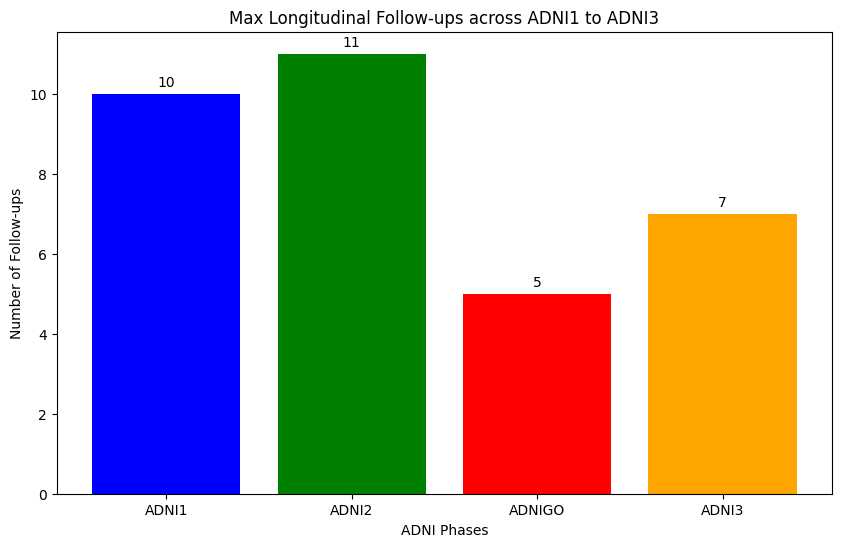

In [ ]:
plt.figure(figsize=(10, 6))
counts = [adni1_max_followup, adni2_max_followup, adnigo_max_follow, adni3_max_follow]
labels = ['ADNI1', 'ADNI2', 'ADNIGO', 'ADNI3']
colors = ['blue', 'green', 'red', 'orange']

bars = plt.bar(labels, counts, color=colors)

for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                                 xy=(bar.get_x() + bar.get_width() / 2, height),
                                 xytext=(0, 3),  
                                 textcoords="offset points",
                                 ha='center', va='bottom')

plt.title("Max Longitudinal Follow-ups across ADNI1 to ADNI3")
plt.xlabel("ADNI Phases")
plt.ylabel("Number of Follow-ups")
plt.show()

In [27]:
adni_use

,RID,COLPROT,ORIGPROT,VISCODE,DX_bl,DX,AGE,M
0,2,ADNI1,ADNI1,bl,CN,CN,74.3,0
1,3,ADNI1,ADNI1,bl,AD,Dementia,81.3,0
2,3,ADNI1,ADNI1,m06,AD,Dementia,81.3,6
3,3,ADNI1,ADNI1,m12,AD,Dementia,81.3,12
4,3,ADNI1,ADNI1,m24,AD,Dementia,81.3,24
...,...,...,...,...,...,...,...,...
16416,4349,ADNI3,ADNI2,m138,CN,NaN,71.4,138
16417,6801,ADNI3,ADNI3,m42,SMC,NaN,61.0,42
16418,5097,ADNI3,ADNI2,m126,SMC,NaN,67.5,126
16419,6515,ADNI3,ADNI3,m60,SMC,NaN,89.9,60


In [28]:
adni2_baseline = adni_use[(adni_use["COLPROT"] == "ADNI2") & (
    adni_use["VISCODE"] == "bl")]
adni2_rids = adni2_baseline["RID"].unique()

In [29]:
adni2_longitudinal = adni_use[adni_use["RID"].isin(
    adni2_rids)].sort_values(["RID", "VISCODE"])

In [30]:
adni2_longitudinal['DX_bl'].value_counts()

CN      1681
EMCI    1447
LMCI    1324
AD       730
SMC      670
Name: DX_bl, dtype: int64

In [31]:
adni2_longitudinal['DX'].value_counts()

MCI         1686
CN          1559
Dementia     736
Name: DX, dtype: int64

In [32]:
print(adni2_longitudinal['RID'].nunique())

790


In [33]:
adni2_longitudinal.groupby(["DX_bl",'DX'])['RID'].nunique()

DX_bl  DX      
AD     Dementia    148
       MCI           2
CN     CN          186
       Dementia      8
       MCI          37
EMCI   CN           24
       Dementia     33
       MCI         179
LMCI   CN           13
       Dementia     82
       MCI         163
SMC    CN          106
       Dementia      4
       MCI          22
Name: RID, dtype: int64

In [34]:
adni2_longitudinal.groupby(["DX_bl", "DX"])['RID'].nunique()

DX_bl  DX      
AD     Dementia    148
       MCI           2
CN     CN          186
       Dementia      8
       MCI          37
EMCI   CN           24
       Dementia     33
       MCI         179
LMCI   CN           13
       Dementia     82
       MCI         163
SMC    CN          106
       Dementia      4
       MCI          22
Name: RID, dtype: int64

In [35]:
transition_counts = {}  
conversion_details = []  

for rid, group in adni2_longitudinal.groupby('RID'):
    group = group.sort_values('M') 
    baseline_dx = group['DX_bl'].iloc[0]  
    baseline_viscode = group['VISCODE'].iloc[0]  

    previous_dx = baseline_dx  

    for index, row in group.iterrows():
        current_dx = row['DX']

        if pd.notna(previous_dx) and pd.notna(current_dx) and previous_dx != current_dx:
            transition_key = f"{previous_dx} → {current_dx}"

            
            if transition_key in transition_counts:
                transition_counts[transition_key] += 1
            else:
                transition_counts[transition_key] = 1

            conversion_details.append(
                (rid, baseline_viscode, baseline_dx, row['VISCODE'], current_dx, transition_key))

        previous_dx = current_dx  



In [36]:
transition = pd.DataFrame(conversion_details, columns=[
    'RID', 'Baseline_VISCODE', 'Baseline_DX', 'Transition_VISCODE', 'Transition_DX', 'Transition'])

In [37]:
adni2_longitudinal[ ~adni2_longitudinal['RID'].isin(transition['RID'].unique())].groupby(['DX_bl','DX'])['RID'].nunique()

DX_bl  DX      
CN     CN          161
       Dementia      1
       MCI          13
Name: RID, dtype: int64

In [38]:
adni2_longitudinal[(~adni2_longitudinal['RID'].isin(transition['RID'].unique())) & 
                   (adni2_longitudinal['DX'] != 'CN') & 
                   (adni2_longitudinal['DX'].notna())]

,RID,COLPROT,ORIGPROT,VISCODE,DX_bl,DX,AGE,M
12031,4041,ADNI2,ADNI2,m06,CN,MCI,77.9,6
12032,4041,ADNI2,ADNI2,m12,CN,MCI,77.9,12
12034,4041,ADNI2,ADNI2,m24,CN,Dementia,77.9,24
12036,4041,ADNI2,ADNI2,m36,CN,Dementia,77.9,36
12037,4041,ADNI2,ADNI2,m48,CN,Dementia,77.9,48
13427,4041,ADNI3,ADNI2,m78,CN,Dementia,77.9,78
9038,4071,ADNI2,ADNI2,m24,CN,MCI,84.5,24
9036,4071,ADNI2,ADNI2,m36,CN,MCI,84.5,36
9035,4071,ADNI2,ADNI2,m48,CN,MCI,84.5,48
9034,4071,ADNI2,ADNI2,m60,CN,MCI,84.5,60


In [39]:
transition[transition['RID']==4577]

,RID,Baseline_VISCODE,Baseline_DX,Transition_VISCODE,Transition_DX,Transition


In [40]:
adni2_longitudinal[adni2_longitudinal['RID']==4577]

,RID,COLPROT,ORIGPROT,VISCODE,DX_bl,DX,AGE,M
4710,4577,ADNI2,ADNI2,bl,CN,CN,84.7,0
4709,4577,ADNI2,ADNI2,m03,CN,NaN,84.7,3
4708,4577,ADNI2,ADNI2,m06,CN,MCI,84.7,6
4707,4577,ADNI2,ADNI2,m12,CN,MCI,84.7,12
4706,4577,ADNI2,ADNI2,m18,CN,NaN,84.7,18
4705,4577,ADNI2,ADNI2,m24,CN,MCI,84.7,24


In [41]:
baseline_counts = adni2_longitudinal.groupby('DX_bl')['RID'].nunique()
transition_rids = transition['RID'].unique()
transition_counts = adni2_longitudinal[adni2_longitudinal['RID'].isin(
    transition_rids)].groupby('DX_bl')['RID'].nunique()
stable_counts = baseline_counts - transition_counts
transition_summary = pd.DataFrame({
    'Total Participants': baseline_counts,
    'Transitioned': transition_counts.fillna(0).astype(int),
    'Stable': stable_counts.fillna(0).astype(int)
})

In [42]:
transition_summary

,Total Participants,Transitioned,Stable
DX_bl,,,
AD,151,148,3
CN,188,25,163
EMCI,181,179,2
LMCI,164,163,1
SMC,106,106,0


In [43]:
adni2_longitudinal[adni2_longitudinal['DX_bl'] =='SMC'].groupby('DX')['RID'].nunique()

DX
CN          106
Dementia      4
MCI          22
Name: RID, dtype: int64

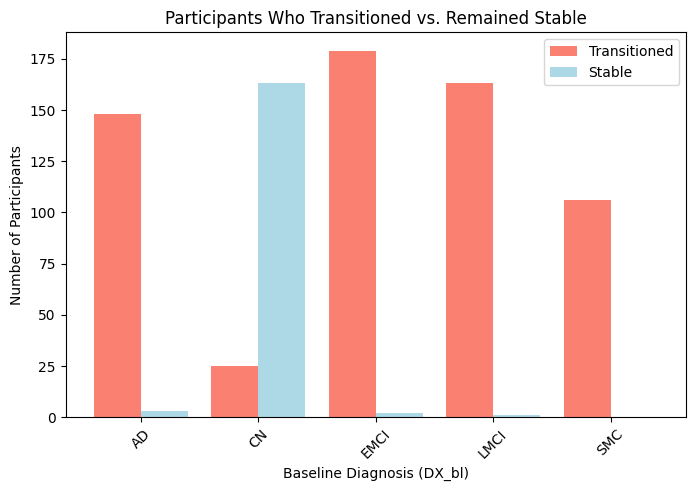

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))

bar_width = 0.4
x_labels = transition_summary.index
x = np.arange(len(x_labels))

ax.bar(x - bar_width/2, transition_summary['Transitioned'],
       width=bar_width, color='salmon', label='Transitioned')
ax.bar(x + bar_width/2, transition_summary['Stable'],
       width=bar_width, color='lightblue', label='Stable')

ax.set_xlabel("Baseline Diagnosis (DX_bl)")
ax.set_ylabel("Number of Participants")
ax.set_title("Participants Who Transitioned vs. Remained Stable")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45)
ax.legend()

plt.show()

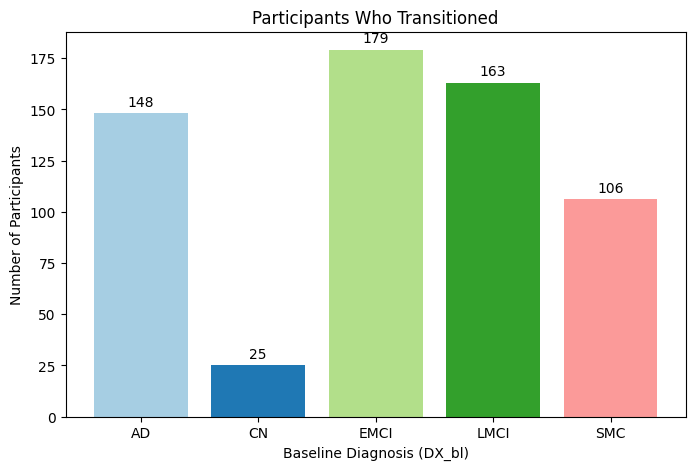

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
labels = transition_summary.index
sizes = transition_summary['Transitioned']

bars = ax.bar(labels, sizes, color=plt.cm.Paired.colors)

for bar in bars:
       height = bar.get_height()
       ax.annotate(f'{height}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

ax.set_title("Participants Who Transitioned")
ax.set_xlabel("Baseline Diagnosis (DX_bl)")
ax.set_ylabel("Number of Participants")

plt.show()

,RID,COLPROT,ORIGPROT,VISCODE,DX_bl,DX,AGE,M
9258,4001,ADNI2,ADNI2,bl,AD,Dementia,88.5,0
9257,4001,ADNI2,ADNI2,m03,AD,NaN,88.5,3
9256,4001,ADNI2,ADNI2,m06,AD,Dementia,88.5,6
9255,4001,ADNI2,ADNI2,m12,AD,Dementia,88.5,12
9254,4001,ADNI2,ADNI2,m18,AD,NaN,88.5,18
...,...,...,...,...,...,...,...,...
11232,5296,ADNI2,ADNI2,m24,SMC,CN,69.3,24
14392,5296,ADNI3,ADNI2,m60,SMC,CN,69.3,60
13066,5296,ADNI3,ADNI2,m72,SMC,NaN,69.3,72
13240,5296,ADNI3,ADNI2,m84,SMC,CN,69.3,84


In [167]:
longitudinal_duration = adni2_longitudinal.groupby(
    'RID')['M'].agg(['min', 'max'])
longitudinal_duration['Followup_Duration'] = longitudinal_duration['max'] - \
    longitudinal_duration['min']

In [168]:
duration_counts = longitudinal_duration['Followup_Duration'].value_counts(
).sort_index()

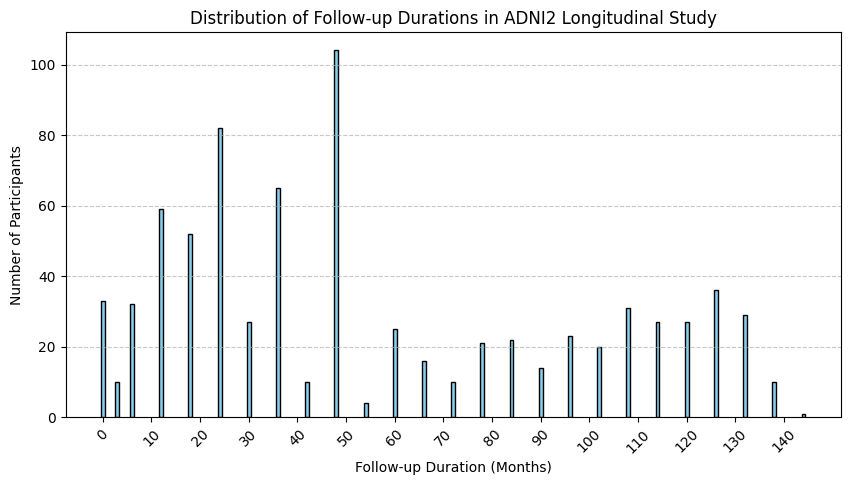

In [175]:
plt.figure(figsize=(10, 5))
plt.bar(duration_counts.index, duration_counts.values,
        color='skyblue', edgecolor='black')
plt.xlabel("Follow-up Duration (Months)")
plt.ylabel("Number of Participants")
plt.title("Distribution of Follow-up Durations in ADNI2 Longitudinal Study")
plt.xticks(rotation=45)
plt.xscale('linear')
plt.xticks(np.arange(0, max(duration_counts.index) + 1, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [177]:
npiq = pd.read_csv("All_Subjects_NPIQ_07Feb2025.csv")

In [182]:
npiq_use = npiq[['PHASE','RID','VISCODE2','NPIK','NPIKSEV']]

In [183]:
adni2_rids = set(adni2_longitudinal['RID'].unique())
npiq_adni2 = npiq_use[npiq_use['RID'].isin(adni2_rids)] 

In [184]:
npiq_available = npiq_adni2['RID'].nunique()
total_adni2_participants = len(adni2_rids)
missing_npiq = total_adni2_participants - npiq_available
print(f"Total ADNI2 Participants: {total_adni2_participants}")
print(f"Participants with Available NPI-Q Data: {npiq_available}")
print(f"Participants without NPI-Q Data: {missing_npiq}")

Total ADNI2 Participants: 790
Participants with Available NPI-Q Data: 732
Participants without NPI-Q Data: 58


In [185]:
severity_counts = npiq_adni2['NPIKSEV'].value_counts().sort_index()

In [191]:
npiq_adni2 = npiq_adni2.rename(columns={"VISCODE2":"VISCODE"})

In [193]:
merged = adni2_longitudinal.merge(npiq_adni2, on=['RID','VISCODE'], how='inner')

In [195]:
merged['RID'].nunique()

732

In [199]:
merged.groupby(['NPIKSEV','NPIK'])['RID'].nunique()

NPIKSEV  NPIK
1.0      1.0     151
2.0      1.0      75
3.0      1.0      15
Name: RID, dtype: int64

In [203]:
merged.groupby('NPIK')['RID'].nunique()    

NPIK
0.0    650
1.0    214
2.0      6
Name: RID, dtype: int64

In [210]:
merged[(merged['NPIK']==1) | (merged['NPIK']==2)].groupby('NPIKSEV')['RID'].nunique()

NPIKSEV
1.0    151
2.0     75
3.0     15
Name: RID, dtype: int64

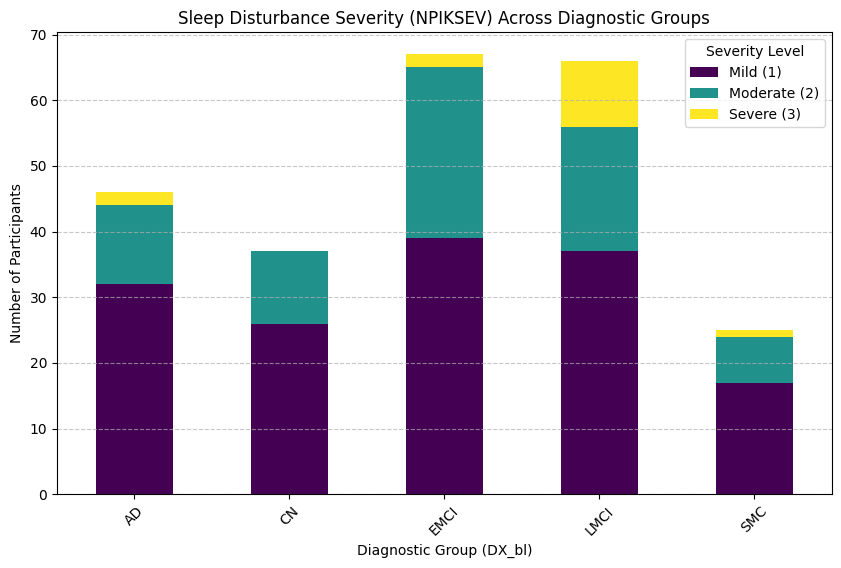

In [ ]:
severity_analysis = merged[['RID', 'DX_bl', 'NPIKSEV']].dropna()

severity_counts = severity_analysis.groupby(['DX_bl', 'NPIKSEV'])[
    'RID'].nunique().unstack(fill_value=0)

severity_counts.plot(kind='bar', stacked=True,
                     colormap='viridis', figsize=(10, 6))

plt.title('Sleep Disturbance Severity (NPIKSEV) Across Diagnostic Groups')
plt.xlabel('Diagnostic Group (DX_bl)')
plt.ylabel('Number of Participants')
plt.legend(title='Severity Level', labels=[
           'Mild (1)', 'Moderate (2)', 'Severe (3)'])
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [215]:
visit_counts = merged.groupby('RID')['VISCODE'].nunique()

# Convert to DataFrame for better readability
visit_counts_df = visit_counts.reset_index()
visit_counts_df.columns = ['RID', 'Number_of_Visits']

In [217]:
import seaborn as sns 

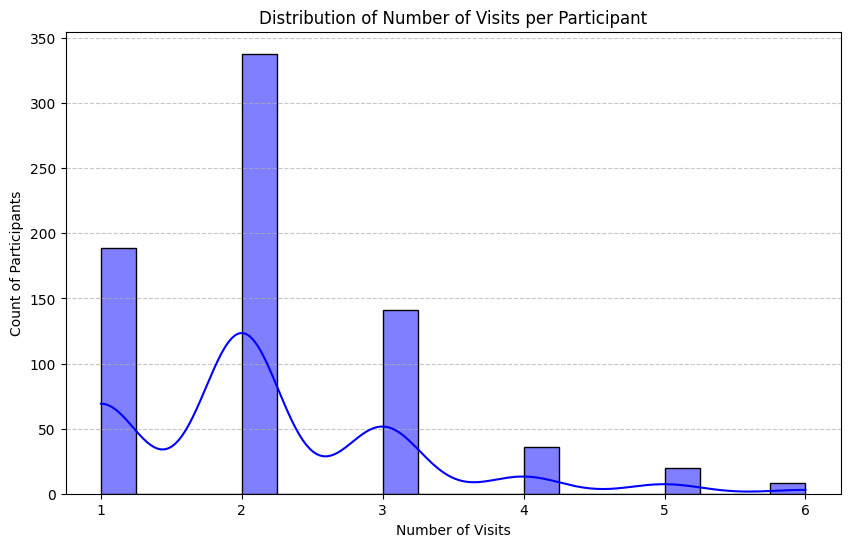

In [218]:
plt.figure(figsize=(10, 6))
sns.histplot(visit_counts_df['Number_of_Visits'],
             bins=20, kde=True, color='blue')

plt.title('Distribution of Number of Visits per Participant')
plt.xlabel('Number of Visits')
plt.ylabel('Count of Participants')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

       count      mean       std  min  25%  50%  75%  max
DX_bl                                                    
AD     133.0  1.526316  0.516089  1.0  1.0  2.0  2.0  3.0
CN     182.0  2.857143  1.257652  1.0  2.0  3.0  3.0  6.0
EMCI   163.0  2.184049  0.890549  1.0  2.0  2.0  3.0  5.0
LMCI   158.0  2.113924  0.667486  1.0  2.0  2.0  2.0  4.0
SMC     96.0  1.739583  0.943061  1.0  1.0  1.0  2.0  4.0


C:\Users\anisr\AppData\Local\Temp\ipykernel_16768\4269506635.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=visit_counts, x='DX_bl', y='Number_of_Visits', palette='Set2')


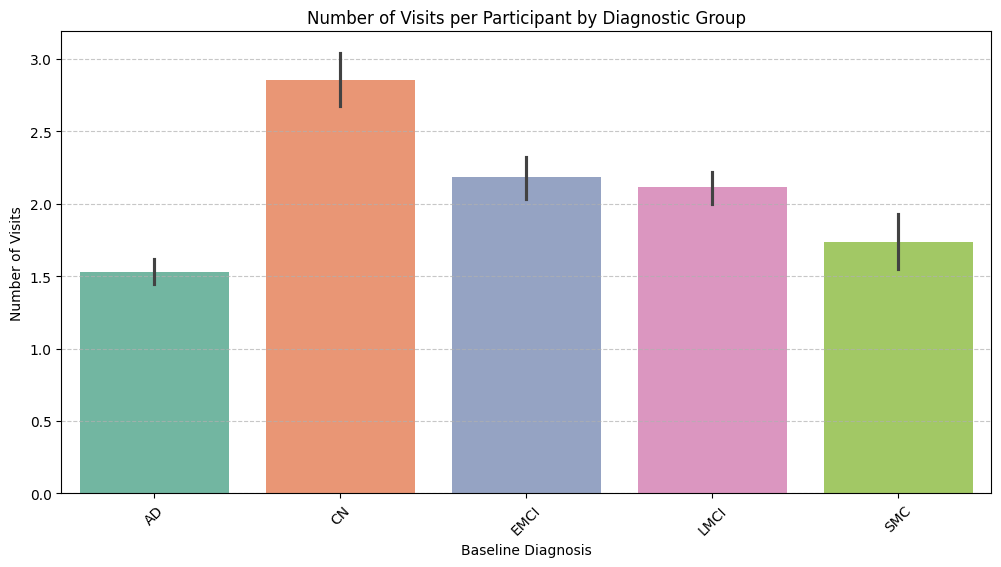

In [220]:
visit_counts = merged.groupby(['RID', 'DX_bl'])[
    'VISCODE'].nunique().reset_index()
visit_counts.columns = ['RID', 'DX_bl', 'Number_of_Visits']

visit_summary = visit_counts.groupby('DX_bl')['Number_of_Visits'].describe()
print(visit_summary)

plt.figure(figsize=(12, 6))
sns.barplot(data=visit_counts, x='DX_bl', y='Number_of_Visits', palette='Set2')

plt.title('Number of Visits per Participant by Diagnostic Group')
plt.xlabel('Baseline Diagnosis')
plt.ylabel('Number of Visits')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()